# Data Preparation - Nova Iguacu

This notebook extracts terrain proportions from neighborhood maps and decomposes
neighborhood-level OVT and ADT data into terrain-specific values.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from scipy import optimize
from scipy.stats import pearsonr
import readHistData as hist

## 1. Load Observed Data from CSV

In [2]:
df = pd.read_csv('../data/NovaIguacu.csv')
print(f"Loaded {len(df)} rows of data")
df.head()

Loaded 12 rows of data


,ADT_Cabuçu,ADT_Ceramica,ADT_Moqueta,OVT_Cabuçu,OVT_Ceramica,OVT_Moqueta,month,mean_prec,mean_t_min,mean_t_med,mean_t_max
0,15.789474,27.173913,28.571429,NaN,67.272727,63.025210,2011_07,2.900,15.853571,20.887500,25.921429
1,14.285714,18.279570,29.591837,NaN,70.833333,65.546218,2011_08,4.175,17.128571,22.348214,27.567857
2,8.163265,13.483146,22.680412,NaN,47.457627,45.378151,2011_09,5.475,17.639286,22.498214,27.357143
3,9.000000,10.000000,23.232323,NaN,55.932203,57.627119,2011_10,9.075,18.321429,23.076786,27.832143
4,11.000000,25.000000,28.000000,NaN,78.070175,68.067227,2011_11,2.675,18.760714,23.414286,28.067857


In [3]:
days = [i * 30 for i in range(len(df))]

# Note: CSV uses Cabuçu but OVT_Cabuçu column is completely empty
# Handle by using average of other neighborhoods
CeramicaOVT_raw = df['OVT_Ceramica'].ffill().bfill()
MoquetaOVT_raw = df['OVT_Moqueta'].ffill().bfill()

# Check if OVT_Cabuçu is completely empty
if df['OVT_Cabuçu'].isnull().all():
    print("Note: OVT_Cabuçu is completely empty - using average of Ceramica and Moqueta")
    CabucuOVT = ((CeramicaOVT_raw + MoquetaOVT_raw) / 2).values
else:
    CabucuOVT = df['OVT_Cabuçu'].ffill().bfill().values

CeramicaOVT = CeramicaOVT_raw.values
MoquetaOVT = MoquetaOVT_raw.values

CabucuADT = df['ADT_Cabuçu'].ffill().bfill().values
CeramicaADT = df['ADT_Ceramica'].ffill().bfill().values
MoquetaADT = df['ADT_Moqueta'].ffill().bfill().values

print(f"Days: {days}")
print(f"Number of time points: {len(days)}")

Note: OVT_Cabuçu is completely empty - using average of Ceramica and Moqueta
Days: [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
Number of time points: 12


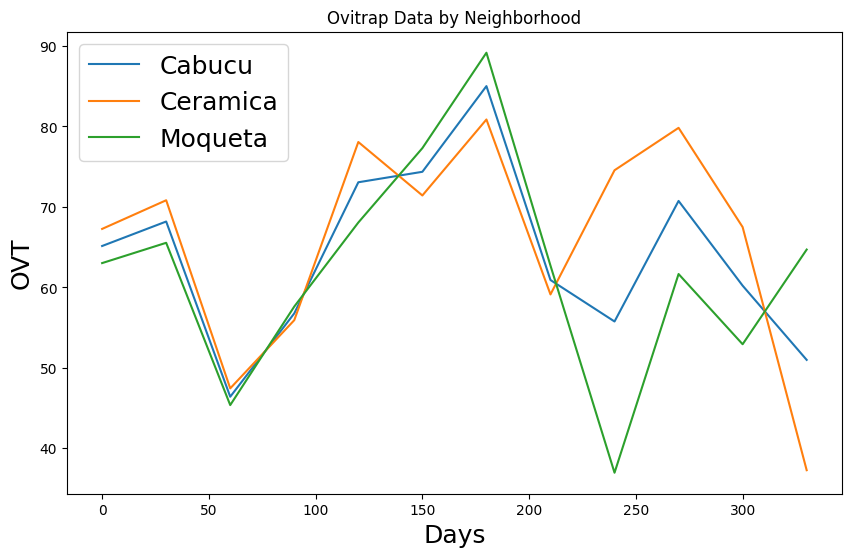

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(days, CabucuOVT, label='Cabucu')
plt.plot(days, CeramicaOVT, label='Ceramica')
plt.plot(days, MoquetaOVT, label='Moqueta')
plt.legend(fontsize=18)
plt.xlabel("Days", fontsize=18)
plt.ylabel("OVT", fontsize=18)
plt.title("Ovitrap Data by Neighborhood")
plt.show()

## 2. Extract Terrain Proportions from Maps

In [5]:
def isGreen(rgb):
    r, g, b = rgb
    if g > r and g > b and g > 50:
        return True
    if g > 40 and g > r * 0.9 and g > b * 1.1:
        return True
    return False

def isStreet(rgb_map):
    r, g, b = rgb_map
    if b > r and 200 < b < 245 and 200 < g < 235:
        if abs(r - g) < 30:
            return True
    return False

def isWater(rgb_map):
    r, g, b = rgb_map
    if b > 200 and b > r + 50 and b > g + 30:
        return True
    return False

def count_terrain_from_images(roadmap_path, satellite_path):
    roadmap = Image.open(roadmap_path).convert('RGB')
    satellite = Image.open(satellite_path).convert('RGB')
    width, height = roadmap.size
    if satellite.size != (width, height):
        satellite = satellite.resize((width, height))
    water, parks, streets, houses = 0, 0, 0, 0
    step = 3
    for x in range(0, width, step):
        for y in range(0, height, step):
            pixel_map = roadmap.getpixel((x, y))[:3]
            pixel_sat = satellite.getpixel((x, y))[:3]
            if isWater(pixel_map):
                water += 1
            elif isStreet(pixel_map):
                streets += 1
            elif isGreen(pixel_sat):
                parks += 1
            else:
                houses += 1
    return [water, parks, streets, houses]

In [6]:
# Map folder names (without accents)
neighborhoods_folders = ['Cabucu', 'Ceramica', 'Moqueta']
neighborhoods_display = ['Cabucu', 'Ceramica', 'Moqueta']
map_base_path = '../maps/NovaIguacu_RJ'

proportions_raw = []
for neighborhood in neighborhoods_folders:
    roadmap_path = f"{map_base_path}/{neighborhood}/roadmap.png"
    satellite_path = f"{map_base_path}/{neighborhood}/satellite.png"
    print(f"Processing {neighborhood}...")
    counts = count_terrain_from_images(roadmap_path, satellite_path)
    print(f"  Raw counts [water, parks, streets, houses]: {counts}")
    proportions_raw.append(counts)

Processing Cabucu...
  Raw counts [water, parks, streets, houses]: [0, 22095, 24422, 135812]
Processing Ceramica...
  Raw counts [water, parks, streets, houses]: [0, 7778, 31218, 143333]
Processing Moqueta...
  Raw counts [water, parks, streets, houses]: [0, 15480, 22603, 144246]


In [7]:
proportions = [np.array(c) / sum(c) for c in proportions_raw]
matProporcoes = np.matrix(proportions)

print("Proportions [water, parks, streets, houses]:")
for name, props in zip(neighborhoods_display, proportions):
    print(f"  {name}: water={props[0]:.4f}, parks={props[1]:.4f}, streets={props[2]:.4f}, houses={props[3]:.4f}")
print("\nProportions Matrix:")
print(matProporcoes)

Proportions [water, parks, streets, houses]:
  Cabucu: water=0.0000, parks=0.1212, streets=0.1339, houses=0.7449
  Ceramica: water=0.0000, parks=0.0427, streets=0.1712, houses=0.7861
  Moqueta: water=0.0000, parks=0.0849, streets=0.1240, houses=0.7911

Proportions Matrix:
[[0.         0.12118204 0.13394468 0.74487328]
 [0.         0.04265915 0.17121796 0.78612289]
 [0.         0.08490147 0.12396821 0.79113032]]


## 3. Decompose OVT Data

In [8]:
O_agua, O_parque, O_rua, O_casa = [], [], [], []
OVT_data = [CabucuOVT, CeramicaOVT, MoquetaOVT]

for t in range(len(days)):
    vetOvo = [OVT_data[i][t] for i in range(3)]
    def f(x):
        return np.linalg.norm(matProporcoes @ x - vetOvo)
    result = optimize.minimize(f, [0, 0, 0, 0], bounds=[(0, None)]*4)
    O_agua.append(result.x[0])
    O_parque.append(result.x[1])
    O_rua.append(result.x[2])
    O_casa.append(result.x[3])

O_agua, O_parque, O_rua, O_casa = np.array(O_agua), np.array(O_parque), np.array(O_rua), np.array(O_casa)
print("OVT decomposition complete.")

OVT decomposition complete.


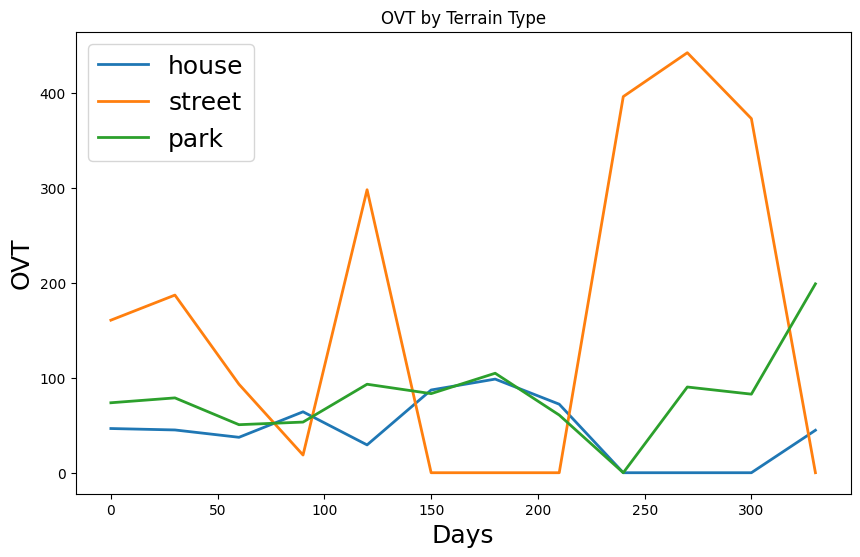

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(days, O_casa, label="house", linewidth=2)
plt.plot(days, O_rua, label="street", linewidth=2)
plt.plot(days, O_parque, label="park", linewidth=2)
plt.legend(fontsize=18)
plt.xlabel("Days", fontsize=18)
plt.ylabel("OVT", fontsize=18)
plt.title("OVT by Terrain Type")
plt.show()

## 4. Decompose ADT Data

In [10]:
ADT_agua, ADT_parque, ADT_rua, ADT_casa = [], [], [], []
ADT_data = [CabucuADT, CeramicaADT, MoquetaADT]

for t in range(len(days)):
    vetAdt = [ADT_data[i][t] for i in range(3)]
    def f(x):
        return np.linalg.norm(matProporcoes @ x - vetAdt)
    result = optimize.minimize(f, [0, 0, 0, 0], bounds=[(0, None)]*4)
    ADT_agua.append(result.x[0])
    ADT_parque.append(result.x[1])
    ADT_rua.append(result.x[2])
    ADT_casa.append(result.x[3])

ADT_agua, ADT_parque, ADT_rua, ADT_casa = np.array(ADT_agua), np.array(ADT_parque), np.array(ADT_rua), np.array(ADT_casa)
print("ADT decomposition complete.")

ADT decomposition complete.


## 5. Validate Reconstruction

In [11]:
reconstructed_OVT = [np.zeros(len(days)) for _ in range(3)]
for t in range(len(days)):
    R = matProporcoes @ [O_agua[t], O_parque[t], O_rua[t], O_casa[t]]
    for i in range(3):
        reconstructed_OVT[i][t] = R[0, i]

print("Reconstruction Correlations (OVT):")
for i, name in enumerate(neighborhoods_display):
    corr = pearsonr(reconstructed_OVT[i], OVT_data[i])[0]
    print(f"  {name}: {corr:.4f}")

Reconstruction Correlations (OVT):
  Cabucu: 0.9814
  Ceramica: 0.9809
  Moqueta: 0.9233


## 6. Save Results

In [12]:
data_new = {
    "Day": days,
    "OVT_house": O_casa,
    "OVT_park": O_parque,
    "OVT_street": O_rua,
    "ADT_house": ADT_casa,
    "ADT_park": ADT_parque,
    "ADT_street": ADT_rua,
    "Temperature": [hist.temperature(t) for t in days],
    "Pluviosity": [hist.pluviosity(t) for t in days]
}

df_new = pd.DataFrame(data_new)
df_new.to_csv("dataNew.csv", index=False)
print("Saved dataNew.csv")
df_new.head(10)

Saved dataNew.csv


,Day,OVT_house,OVT_park,OVT_street,ADT_house,ADT_park,ADT_street,Temperature,Pluviosity
0,0,46.568049,73.712523,160.730824,29.436875,0.000000,8.357402,20.887499999975,2.9
1,30,45.061098,78.849298,187.165693,26.920383,0.000000,0.000000,22.3482142857,4.175000000000001
2,60,37.321145,50.610388,93.212325,19.248862,0.000000,0.000000,22.49821428575,5.475
3,90,64.194129,53.362489,18.638995,18.315805,0.000000,0.000000,23.076785714274997,9.075
4,120,29.310437,93.235965,298.164996,27.796728,0.000000,0.000000,23.414285714275003,2.675
5,150,87.170703,83.341642,0.000000,21.242760,74.434639,0.000000,24.751785714275,20.424999999999997
6,180,98.641400,104.813296,0.000000,23.452929,68.578490,0.000000,26.50535714285,71.675
7,210,72.202319,60.765776,0.000000,7.800557,117.850512,0.000000,27.998214285725,16.775
8,240,0.000000,0.000000,396.324651,10.855036,60.838161,0.000000,28.14107142855,35.025
9,270,0.000000,90.311091,442.536315,10.699252,82.304738,0.000000,26.90357142855,19.275
